In [587]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [735]:
class Single:
    def __init__(self, data, _children=(), _operator='', label=""):
        self.data = data
        self._children = set(_children)
        self._operator = _operator
        self.label = label
        self.gradient = 0.0
        self._backpropagation = lambda: None
    def __repr__(self):
        return f"[data={self.data}]"
    def __add__(self, other):
        other = other if (isinstance(other, Single)) else Single(other)
        output = Single(self.data + other.data, (self, other), '+')

        def _backpropagation():
            self.gradient += 1.0 * output.gradient
            other.gradient += 1.0 * output.gradient
        output._backpropagation = _backpropagation
        
        return output
    def __radd__(self, other):
        return self + other
    def __mul__(self, other):
        other = other if (isinstance(other, Single)) else Single(other)
        output = Single(self.data * other.data, (self, other), '*')

        def _backpropagation():
            self.gradient += other.data * output.gradient
            other.gradient += self.data * output.gradient
        output._backpropagation = _backpropagation

        return output
    def __rmul__(self, other):
        return self * other
    def __neg__(self):
        return -1 * self
    def __sub__(self, other):
        return self + (-other)
    def __rsub__(self, other):
        return (-self) + other
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Error, only (int & float are supported)"
        output = Single(self.data ** other, (self,), f'**{other}')

        def _backpropagation():
            self.gradient += (other * self.data ** (other - 1)) * output.gradient
        output._backpropagation = _backpropagation

        return output
    def __truediv__(self, other):
        return self * (other**-1)
    def __rtruediv__(self, other):
        return (self**-1) * other
    def relu(self):
        output = Single(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backpropagation():
            self.gradient += (output.data > 0) * output.gradient
        output._backpropagation = _backpropagation

        return output
    def sigmoid(self):
        x = self.data
        y = 1 / (1 + math.exp(-x))
        output = Single(y, (self,), 'sigmoid')

        def _backpropagation():
            self.gradient += y * (1 - y) * output.gradient
        output._backpropagation = _backpropagation
        
        return output
    def tanh(self):
        x = self.data
        y = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        output = Single(y, (self, ), 'tanh')
        
        def _backpropagation():
          self.gradient += (1 - y**2) * output.gradient
        output._backpropagation = _backpropagation
    
        return output
    def exp(self):
        x = self.data
        output = Single(math.exp(x), (self,), 'exp')

        def _backpropagation():
            self.gradient += output.data * output.gradient
        output._backpropagation = _backpropagation

        return output
    # 100% copied from Andrej Karpathy's video
    def backpropagation(self):
        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._children:
              build_topo(child)
            topo.append(v)
        build_topo(self)
        
        self.gradient = 1.0
        for node in reversed(topo):
          node._backpropagation()

In [736]:
# 100% copied from Andrej Karpathy's video
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._children:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | gradient %.4f }" % (n.label, n.data, n.gradient), shape='record')
    if n._operator:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._operator, label = n._operator)
      # and connect this node to it
      dot.edge(uid + n._operator, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._operator)

  return dot

In [737]:
f(p1,p2,p3,p4, p...) = p1 * s1 + p2 * s2 + p... * s... 
# if f, returns more than 0: the picture is a car
# if f, returns less than 0: the picture is a duck


x = Single(1)
y = Single(2)
z = x+y
k = 2 * z
a = k ** 2.0
b = 1 / a
b.backpropagation()

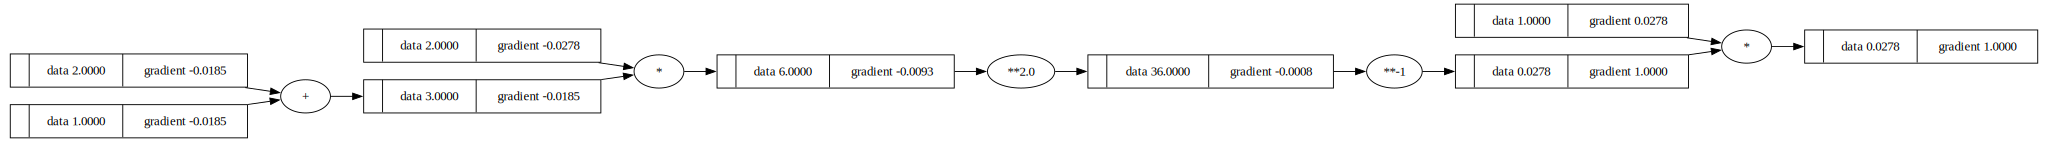

In [738]:
draw_dot(b)

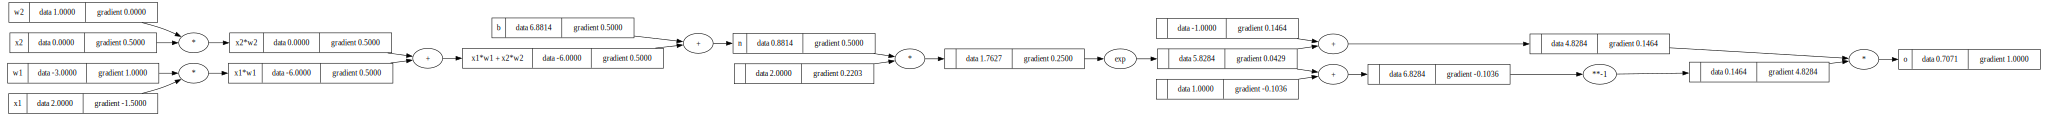

In [739]:
# inputs x1,x2
x1 = Single(2.0, label='x1')
x2 = Single(0.0, label='x2')
# weights w1,w2
w1 = Single(-3.0, label='w1')
w2 = Single(1.0, label='w2')
# bias of the neuron
b = Single(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backpropagation()
draw_dot(o)

In [763]:
class Neuron:
    def __init__(self, num_of_inputs):
        self.weights = [Single(random.uniform(-1, 1)) for i in range(num_of_inputs)]
        self.bias = Single(random.uniform(-1, 1))
    def __call__(self, x):
        activision = sum((weight * input for weight, input in zip(self.weights, x)), self.bias)
        # passing activision through non-linearity, chose tanh because sigmoid was too slow ??
        output = activision.tanh()
        
        return output
    def parameters(self):
        return self.weights + [self.bias]
class Layer:
    def __init__(self, num_of_inputs, num_of_neurons):
        self.neurons = [Neuron(num_of_inputs) for i in range(num_of_neurons)]
    def __call__(self, x):
        output = [n(x) for n in self.neurons]
        return output[0] if len(output) == 1 else output
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
class MLP:
    def __init__(self, num_of_inputs, num_of_neurons_list):
        sizes = [num_of_inputs] + num_of_neurons_list
        self.layers = [Layer(sizes[i], sizes[i+1]) for i in range(len(num_of_neurons_list))]
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    


In [764]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])

In [765]:
#n(x)
#draw_dot(n(x))
n.parameters()

[[data=-0.2789648573761192],
 [data=-0.7755292388303261],
 [data=0.6354029041248819],
 [data=-0.4561625106866589],
 [data=-0.6480816081755212],
 [data=0.15524126074450972],
 [data=0.441385032646066],
 [data=0.94940502086587],
 [data=-0.21739675027439342],
 [data=0.3616836142560975],
 [data=-0.4405568633601671],
 [data=-0.3670675607872913],
 [data=0.9022278469561094],
 [data=0.5631291997426533],
 [data=0.9347056373625731],
 [data=-0.6386574570544648],
 [data=0.4582846823528586],
 [data=-0.1526141228738367],
 [data=0.23062733302353422],
 [data=0.6075646187363906],
 [data=0.6929208465526671],
 [data=-0.07294756476085884],
 [data=-0.6371544674920175],
 [data=-0.3185761310939721],
 [data=0.5680842199589342],
 [data=-0.6305714760183025],
 [data=-0.7773070970658209],
 [data=0.32157715272610266],
 [data=0.35199599100453227],
 [data=-0.4144385024339228],
 [data=0.49563715618556436],
 [data=-0.8969701772926633],
 [data=0.7593459322838947],
 [data=0.47950363122349704],
 [data=0.035727932722994016

In [766]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [767]:
ypreds = [n(x) for x in xs]
ypreds

[[data=-0.8229230160162876],
 [data=-0.8168124450515671],
 [data=-0.6814273064790012],
 [data=-0.4022489198079861]]

In [768]:
loss = sum((ypred - y) ** 2 for ypred, y in zip(ypreds, ys))
loss

[data=5.424396596769792]

In [769]:
for i in range(100):
    # forward pass
    ypreds = [n(x) for x in xs]
    loss = sum((ypred - y) ** 2 for ypred, y in zip(ypreds, ys))
    # backpropagation pass
    for p in n.parameters():
        p.gradient = 0.0
    loss.backpropagation()
    # updating parameters
    for p in n.parameters():
        p.data += -0.1 * p.gradient
    # print state
    print(i, loss.data)

0 5.424396596769792
1 2.0406462791319915
2 1.392390189907709
3 1.0486588660291816
4 0.2665938195087522
5 0.038978022695412944
6 0.03378513565250813
7 0.02977299943001793
8 0.026584126582401897
9 0.023991528167050295
10 0.021844219877185544
11 0.02003793852361556
12 0.0184984192665619
13 0.017171365950079755
14 0.016016186056860587
15 0.015001940242448076
16 0.014104645060217275
17 0.013305430012120492
18 0.01258924955399307
19 0.01194396474069989
20 0.011359676618832831
21 0.010828234521418687
22 0.010342868072063291
23 0.009897908119582789
24 0.009488572551276026
25 0.009110800079899785
26 0.008761119945309653
27 0.008436548810675038
28 0.008134508468042086
29 0.007852759623152496
30 0.007589348217621169
31 0.007342561609612952
32 0.007110892567898463
33 0.006893009504295502
34 0.006687731721596224
35 0.006494008720140919
36 0.0063109028089447855
37 0.006137574423008869
38 0.005973269668947951
39 0.005817309714975757
40 0.005669081714958819
41 0.005528031014411178
42 0.005393654432495